In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
transformations = transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])

In [4]:
def data_loader(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data', train=True, download=True,
                            transform=transformations), batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data', train=False, download=True,
                            transform=transformations), batch_size=test_batch_size, shuffle=True)
    return train_loader, test_loader

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.linear1 = nn.Linear(16*5*5, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        return x

In [6]:
def calculate_sensitivity(model):
    count = 0
    Frobenius_norm = 0
    for param in model.parameters():
        grad = 0.0
        if param.grad is not None:
            count += 1
            grad = param.grad
            Frobenius_norm += torch.linalg.norm(grad).numpy()
    return Frobenius_norm / count

In [8]:
def train_model(model, optimizer, loader, criterion):
    for batch_index, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


In [9]:
def calculate_loss_accuracy(model, loader, criterion):
    total_loss = 0
    loss_count = 0
    correct_samples = 0
    total_samples = 0
    for batch in loader:
        data, target = batch
        pred = model(data)
        loss = criterion(pred, target)
        total_loss += loss
        for i, output_tensor in enumerate(pred):
            if torch.argmax(output_tensor) == target[i]:
                correct_samples += 1
            total_samples += 1
    return total_loss / len(loader), round(correct_samples / total_samples, 3)

In [10]:
def train_model_and_compute(model, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    epochs = 10
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        print(epoch)
        train_model(model, optimizer, train_loader, criterion)
        train_loss, train_acc = calculate_loss_accuracy(model, train_loader, criterion)
        test_loss, test_acc = calculate_loss_accuracy(model, test_loader, criterion)
    print('train_loss: ', train_loss)
    print('test_loss: ', test_loss)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

In [11]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
sensitivity_list = []
batch_sizes = [100, 200, 400, 800, 1000]
learning_rate = 0.01
for batch_size in batch_sizes:
    print(batch_size)
    train_loader, test_loader = data_loader(batch_size, batch_size)
    model = CNN()
    train_model_and_compute(model, learning_rate)
    sensitivity_list.append(calculate_sensitivity(model))

100
1


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.1079, grad_fn=<DivBackward0>)
test_loss:  tensor(0.0985, grad_fn=<DivBackward0>)
200
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.1799, grad_fn=<DivBackward0>)
test_loss:  tensor(0.1655, grad_fn=<DivBackward0>)
400
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(1.7197, grad_fn=<DivBackward0>)
test_loss:  tensor(1.7060, grad_fn=<DivBackward0>)
800
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.6287, grad_fn=<DivBackward0>)
test_loss:  tensor(0.6121, grad_fn=<DivBackward0>)
1000
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.9031, grad_fn=<DivBackward0>)
test_loss:  tensor(0.8781, grad_fn=<DivBackward0>)


In [12]:
print(len(test_loss_list))

5


In [18]:
test_loss_array = []
for loss in test_loss_list:
    test_loss_array.append(loss.data.numpy())

train_loss_array = []
for loss in train_loss_list:
    train_loss_array.append(loss.data.numpy())


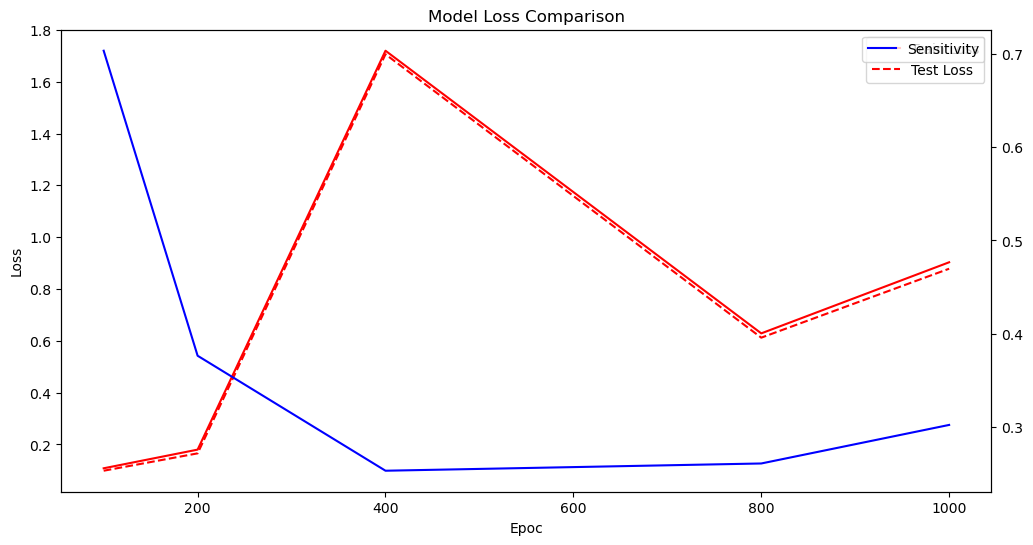

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, train_loss_array, color="r")
plt.plot(batch_sizes, test_loss_array, color="r", linestyle="dashed")
plt.legend(['Train Loss', 'Test Loss'])
plt.title('Model Loss Comparison')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.twinx()
plt.plot(batch_sizes, sensitivity_list, color="b")
plt.legend(['Sensitivity'], loc='upper right')
plt.show()

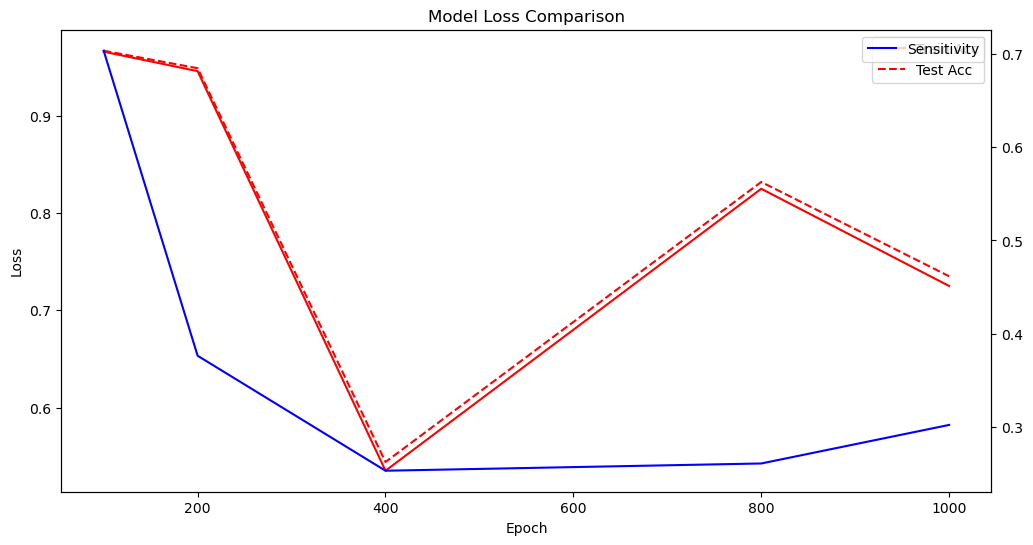

In [29]:
plt.figure(figsize=(12,6))
plt.plot(batch_sizes, train_acc_list, color="r")
plt.plot(batch_sizes, test_acc_list, color="r", linestyle="dashed")
plt.legend(['Train Acc', 'Test Acc'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(batch_sizes, sensitivity_list, color="b")
plt.legend(['Sensitivity'])
plt.title('Model Loss Comparison')
plt.show()
